In [1]:
# pip installs
!pip install lightgbm

In [2]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [6]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'num_comments', 'score', 'total_awards',
                          'author_commentkarma', 'compound_score', 'author_id', 'author_name',
                          'ticker', 'post_type', 'trustworthy', 'author_trust','adjclose_20_X',
                          'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
                          'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
                          'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
                          'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
                          'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
                          'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
                          'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                          'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
                          'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
                          'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y'])

# Apply trust filter
df = df[(df["author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

df

,post_id,date,num_comments,score,total_awards,author_commentkarma,compound_score,author_id,author_name,ticker,...,adjclose_14_Y,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y,trustworthy,author_trust
3,ed0rg2j,2019-01-01,9,6,0.0,744.0,0.3612,2dk1wq99,nightman_123,WSBC,...,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271,1,0.888889
92,ed2x6fn,2019-01-02,2,61,0.0,712.0,0.0516,rw1ynq0,martimook,CPSI,...,25.989721,26.301327,26.496077,26.213688,25.619692,25.366512,25.347040,25.551525,1,0.800000
100,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,ABCB,...,34.241390,34.154694,33.981266,35.175957,36.235764,36.524799,36.476631,36.563339,1,0.857143
101,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,CFFN,...,12.206985,12.251601,12.135600,12.233756,12.198063,11.983905,11.609129,11.559727,1,0.857143
120,ed2ygwl,2019-01-02,0,2,0.0,788.0,0.4404,8wfb2,Crispytender,FANG,...,96.661659,96.537819,96.756943,97.376213,95.556526,95.423157,97.423836,98.243164,1,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940494,ghkrh6s,2020-12-31,1,18,0.0,1283.0,0.3612,ihqbc,keikun2002,WSBC,...,30.700518,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000
940516,ghmxpxm,2020-12-31,0,10,0.0,1283.0,-0.1295,ihqbc,keikun2002,WSBC,...,30.700518,31.364473,31.255468,30.720339,28.926668,29.550983,28.738380,29.313148,1,1.000000
940679,ghldnvu,2020-12-31,0,5,0.0,69.0,0.3818,6mewt3dg,narconocs,EDIT,...,63.790001,65.760002,65.470001,60.680000,60.500000,61.130001,61.349998,62.889999,1,1.000000
940681,ghldnvu,2020-12-31,0,5,0.0,69.0,0.3818,6mewt3dg,narconocs,AUB,...,35.534122,36.596771,36.010822,34.223194,33.239998,33.359173,32.614326,33.369102,1,1.000000


In [7]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'num_comments', 'score', 'total_awards',
       'author_commentkarma', 'compound_score', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust'], dtype=object)

In [8]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [9]:
# Get the X-variable columns
df_X = df[['num_comments', 'score', 'total_awards', 'author_commentkarma',
           'compound_score', 'trustworthy', 'author_trust', 'adjclose_20_X',
           'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
           'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
           'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
           'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
           'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
           'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
           'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
           'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
           'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
           '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
           '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 9.          6.          0.         ... 37.21271133 37.09537888
  36.59896469]
 [ 2.         61.          0.         ... 27.21815872 26.13175964
  26.09296036]
 [ 0.          2.          0.         ... 41.91958237 41.61227036
  41.95799255]
 ...
 [ 0.          3.          0.         ... 12.28999996 11.77000046
  11.93000031]
 [ 0.          3.          0.         ... 30.03000069 30.79000092
  30.86000061]
 [ 2.          2.          0.         ...  2.44000006  2.48000002
   2.55999994]]
[[ 0.          1.          0.         ... 17.25       15.57999992
  14.25      ]
 [ 1.         36.          0.         ... 20.11165619 19.7684536
  19.21932983]
 [ 1.         16.          0.         ... 20.11165619 19.7684536
  19.21932983]
 ...
 [ 0.          5.          0.         ... 30.45000076 28.30999947
  31.29999924]
 [ 0.          5.          0.         ... 24.29444504 26.8253231
  25.41709137]
 [ 1.          9.          1.         ... 13.86999989 13.92000008
  13.18999958]]
[[33.85371017 34.88

In [10]:
# Initialize Model
model = LGBMRegressor(n_estimators=1000)

# Wrap Model for Multiple Outputs
wrapper = MultiOutputRegressor(model).fit(X_train, y_train)

# Wrapper Prediction
ypred = wrapper.predict(X_test)

In [11]:
# Evaluate RMSE
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1])

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1])

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1])

The RMSE for adjClose_2_Y =  34.080971356806764
The RMSE for adjClose_3_Y =  33.35355619822307
The RMSE for adjClose_4_Y =  33.57627914099253
The RMSE for adjClose_5_Y =  34.667743307829795
The RMSE for adjClose_6_Y =  36.36843087045157
The RMSE for adjClose_7_Y =  37.11113245060019
The RMSE for adjClose_8_Y =  36.82491959592647
The RMSE for adjClose_9_Y =  39.35792073228059
The RMSE for adjClose_10_Y =  39.621412908310795
The RMSE for adjClose_11_Y =  40.34350098480717
The RMSE for adjClose_12_Y =  43.586520952087255
The RMSE for adjClose_13_Y =  46.76242229424638
The RMSE for adjClose_14_Y =  46.35740934088877
The RMSE for adjClose_15_Y =  48.83205358393215
The RMSE for adjClose_16_Y =  47.386387499328514
The RMSE for adjClose_17_Y =  48.69735734376442
The RMSE for adjClose_18_Y =  47.91169745498588
The RMSE for adjClose_19_Y =  49.28580280934665
The RMSE for adjClose_20_Y =  51.18312468529956
The RMSE for adjClose_21_Y =  50.282383125036695
The RMSE for 5day_min =  1.675603496576747

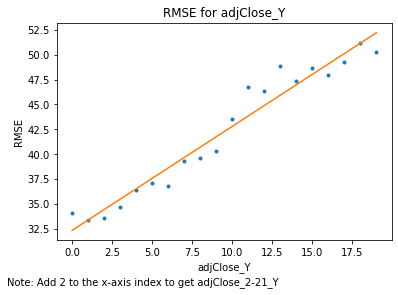

In [12]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [13]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  11.052641066972308
The MAE for adjClose_3_Y =  11.148156497464187
The MAE for adjClose_4_Y =  11.302146669828593
The MAE for adjClose_5_Y =  11.641821069834824
The MAE for adjClose_6_Y =  12.1821732312219
The MAE for adjClose_7_Y =  12.343088333458345
The MAE for adjClose_8_Y =  12.256446803206012
The MAE for adjClose_9_Y =  12.951267322995491
The MAE for adjClose_10_Y =  13.053741402850855
The MAE for adjClose_11_Y =  13.260394823847745
The MAE for adjClose_12_Y =  13.765353412536449
The MAE for adjClose_13_Y =  14.371809444119048
The MAE for adjClose_14_Y =  14.39349523122621
The MAE for adjClose_15_Y =  14.94384354136604
The MAE for adjClose_16_Y =  14.713486110871102
The MAE for adjClose_17_Y =  14.974713725411286
The MAE for adjClose_18_Y =  15.034033170746156
The MAE for adjClose_19_Y =  15.304099209404983
The MAE for adjClose_20_Y =  15.702482050803
The MAE for adjClose_21_Y =  15.356189290707508
The MAE for 5day_min =  1.4552002449164803
The MAE for 

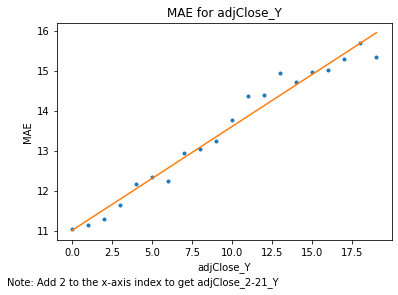

In [14]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()